# -- START --

In [1]:
import matplotlib 
import pandas as pd
import scipy 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.1   
scipy -> 1.7.3
statsmodels -> 0.11.1



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


import warnings


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

### Create DataFrames 

In [3]:
file = Path("../../datasets/Ch8/nyc_taxi.csv")

nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)

### Visualize DataFrames

In [40]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [10]:
nyc_dates = ['11-02-2014', '11-27-2014', '11-28-2014', 
             '12-24-2014', '12-25-2014', '12-31-2014', 
             '01-01-2015', '01-26-2015', '01-27-2015']

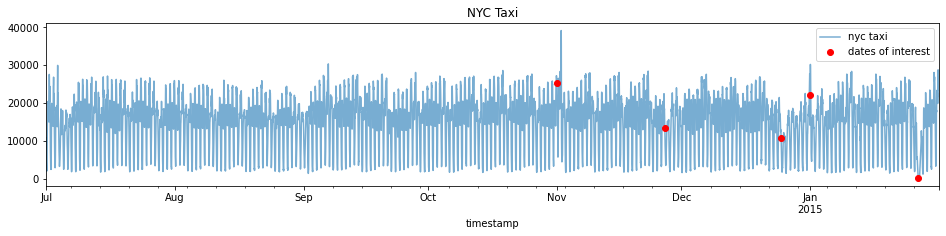

In [33]:
ax = nyc_taxi.plot(title="NYC Taxi", alpha=0.6)
nyc_taxi.loc[nyc_dates].plot(style='ro', ax=ax)
plt.legend(['nyc taxi', 'dates of interest'])

# traffic.plot(title="Traffic Data: Speed")

<AxesSubplot:xlabel='timestamp'>

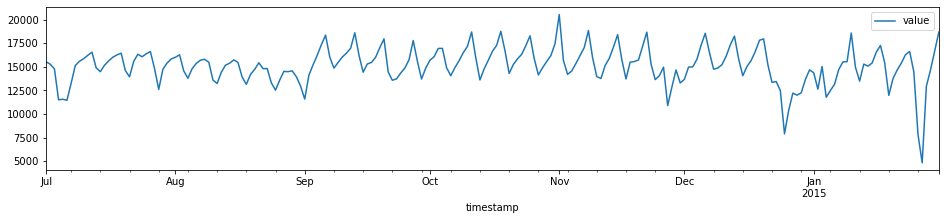

In [34]:
nyc_taxi.resample('D').mean().plot()

# Detecting Outliers using K-Nearest Neighbors

In [4]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

In [105]:
from pyod.models.knn import KNN

In [106]:
nyc_daily = nyc_taxi.resample('D').mean()

In [107]:
nyc_daily.shape

(215, 1)

In [108]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

In [109]:
knn.fit(nyc_daily)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [110]:
predicted = pd.Series(knn.predict(nyc_daily), 
                      index=nyc_daily.index)

In [111]:
predicted

timestamp
2014-07-01    0
2014-07-02    0
2014-07-03    0
2014-07-04    0
2014-07-05    0
             ..
2015-01-27    1
2015-01-28    0
2015-01-29    0
2015-01-30    0
2015-01-31    0
Freq: D, Length: 215, dtype: int64

In [112]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [113]:
nyc_daily.loc[nyc_dates]

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [114]:
outliers = predicted[predicted == 1]
outliers = nyc_daily.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


## There is more

In [144]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'bottom',
                 labels=False):
    
    # min_range = outliers.index.min()
    # max_range = outliers.index.max()
    #ax = data.loc[min_range:max_range].plot(linewidth=3)
    ax = data.plot(alpha=0.6)
    
    plt.title(f'NYC Taxi Outlier data points using {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
    
    plt.legend(['original data','Outliers'])    
    plt.show()

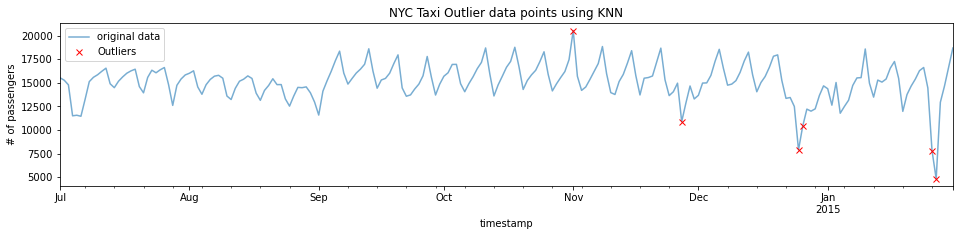

In [145]:
plot_outliers(outliers, nyc_daily, 'KNN')

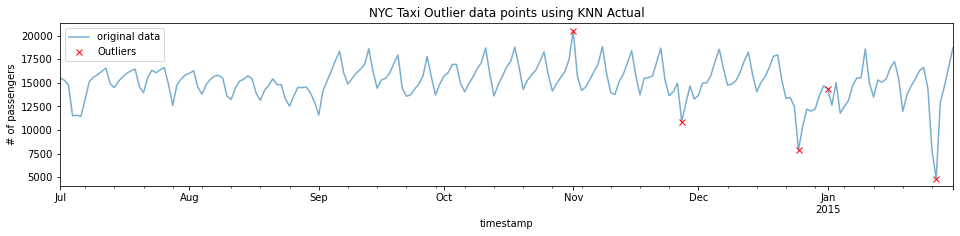

In [142]:
plot_outliers(nyc_daily.loc[nyc_dates], nyc_daily, 'KNN Actual')

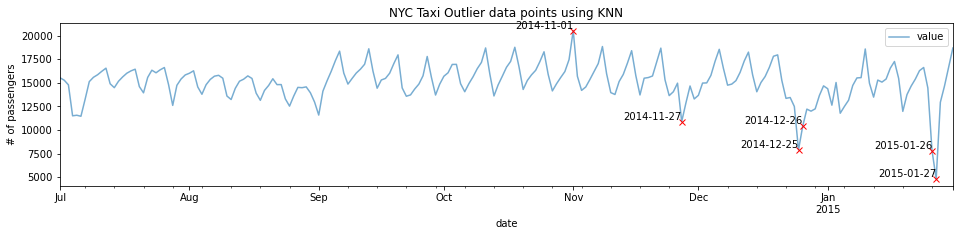

In [128]:
plot_outliers(outliers, 
              nyc_daily, 
              'KNN',
              labels=True)

# Detecting Outliers using Isolation Forests

In [96]:
from pyod.models.iforest import IForest

In [97]:
nyc_daily = nyc_taxi.resample('D').mean()

In [98]:
nyc_daily.shape

(215, 1)

In [99]:
iforest = IForest(contamination=0.03,
                 n_estimators=100,
                 random_state=0)
iforest.fit(nyc_daily)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=0, verbose=0)

In [100]:
predicted = pd.Series(iforest.predict(nyc_daily), 
                      index=nyc_daily.index)

In [101]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [102]:
outliers = predicted[predicted == 1]
outliers = nyc_daily.loc[outliers.index] 
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


## There is more

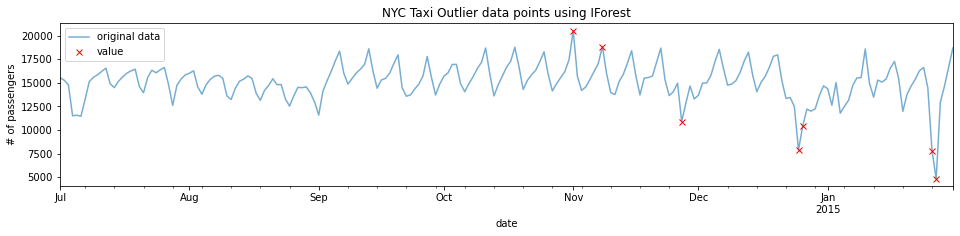

In [103]:
plot_outliers(outliers, nyc_daily, 'IForest')

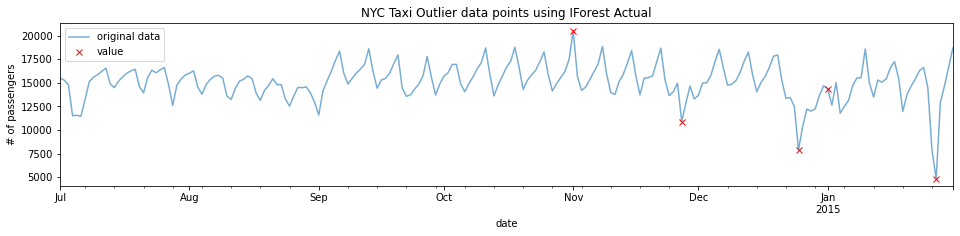

In [104]:
plot_outliers(nyc_daily.loc[nyc_dates], nyc_daily, 'IForest Actual')

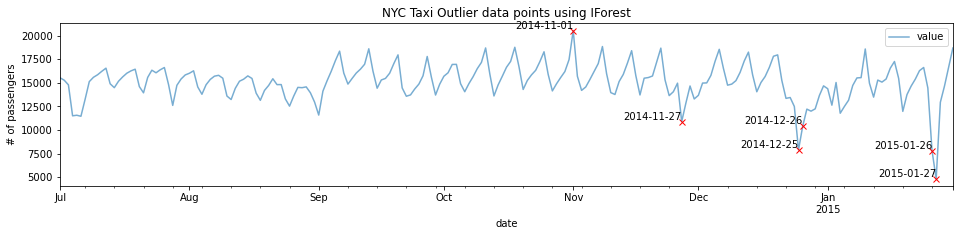

In [133]:
plot_outliers(outliers, 
              nyc_daily, 
              'IForest',
              labels=True)

In [70]:
nyc_taxi.loc['2014-07-04':'2014-07-07'].resample('D').min()

,value
timestamp,
2014-07-04,3276
2014-07-05,2514
2014-07-06,2510
2014-07-07,1877


# Detecing Outliers using Copula-Based Outlier Detection (COPOD)

In [72]:
from pyod.models.copod import COPOD

In [90]:
nyc_daily = nyc_taxi.resample('D').mean()

copod = COPOD(contamination=0.03)
copod.fit(nyc_daily)

COPOD(contamination=0.03, n_jobs=1)

In [91]:
predicted = pd.Series(copod.predict(nyc_daily), 
                      index=nyc_daily.index)

In [92]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [93]:
outliers = predicted[predicted == 1]
outliers = nyc_daily.loc[outliers.index] 
outliers

,value
timestamp,
2014-07-04,11511.770833
2014-07-06,11464.270833
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


## There is more

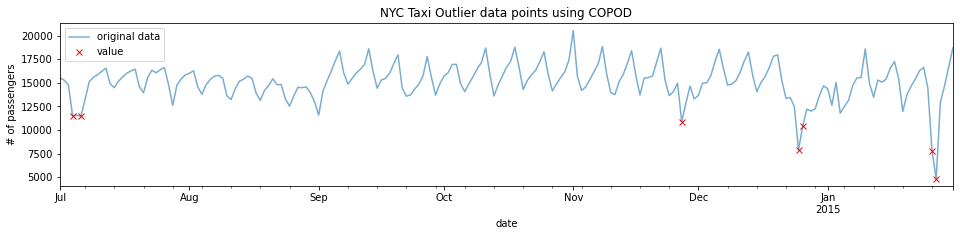

In [94]:
plot_outliers(outliers, nyc_daily, 'COPOD')

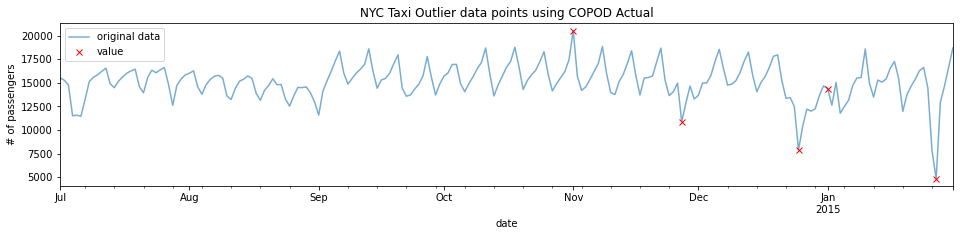

In [95]:
plot_outliers(nyc_daily.loc[nyc_dates], nyc_daily, 'COPOD Actual')

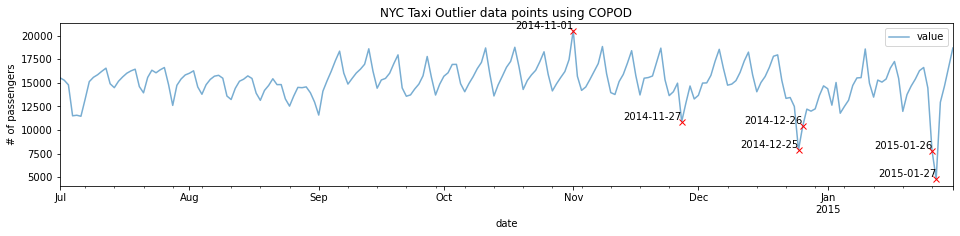

In [130]:
plot_outliers(outliers, 
              nyc_daily, 
              'COPOD',
              labels=True)